In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

import multiprocessing
num_cores = multiprocessing.cpu_count()
from joblib import parallel_backend, Parallel, delayed
from dask.distributed import Client
client = Client()

import glob
import gc

from sklearn.model_selection import train_test_split

2023-08-26 11:17:44.944186: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-26 11:17:44.959782: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-26 11:17:45.075977: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-26 11:17:45.076792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 11:17:45.829662: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
input_shape = (512, 640, 1)
output_channels = 1
sigma_noise = 0
channels_list = [128 , 64 , 32]
#channels_list = [32, 32, 64, 128]

def unet():
    unet_input = tf.keras.layers.Input(shape=input_shape)

    list_features = []
    x = unet_input
    for i, n_channels in enumerate(channels_list):
        x = tf.keras.layers.Conv2D(n_channels, 3, activation='elu', kernel_initializer='he_normal', padding='same', name=f'Encoder_conv_{i}')(x)
        #print(f'encoder layer number {i} number of channel {n_channels}')
        list_features.append((n_channels, x))
        x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)


    for i, (n_channels, same_reso_features) in enumerate(reversed(list_features)):
        #print(f'decoder layer number {i} number of channel {n_channels}')
        #print(f'concat decoder layer number {i} number of channel {same_reso_features}')
        x = tf.keras.layers.UpSampling2D(2)(x)
        x = tf.keras.layers.Concatenate(axis=-1)([x, same_reso_features])
        x = tf.keras.layers.Conv2D(n_channels, 3, activation='elu', padding='same', kernel_initializer='he_normal', name=f'Decoder_conv_{i}')(x)

    if sigma_noise > 0:
            x = tf.keras.layers.GaussianNoise(sigma_noise)(x)

    unet_output = tf.keras.layers.Conv2D(output_channels, 3, activation='sigmoid', padding='same')(x)

    model = tf.keras.Model(unet_input, unet_output, name='unet')

    return model

In [7]:
gc.collect()

21

In [4]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()

model = unet()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [5]:
def open_fits_with_mask(filename):
    image = fits.open(filename)
    cloud = image[0].data
    mask = image[1].data

    del image
    
    return cloud , mask

In [8]:
images_list = glob.glob('../MASKED_SUBSET/*.fits')

In [9]:
import random
images_list = random.choices(images_list, k=1000)

In [10]:
with parallel_backend('threading', n_jobs=num_cores):
    l_fits = Parallel(verbose=5)(delayed(open_fits_with_mask)(filename=r) for r in images_list)
l_fits = np.array(l_fits)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.1s finished


In [11]:
gc.collect()

460

In [12]:
from tensorflow.keras.utils import Sequence

class CloudImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_data, y_data, batch_size, shuffle=True):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.x_data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_indices = self.indices[start_idx:end_idx]

        batch_x = self.x_data[batch_indices]
        batch_y = self.y_data[batch_indices]

        # You can perform any preprocessing here before returning the batch

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [13]:
images_cloud = l_fits[:,0]
mask_cloud = l_fits[:,1]

In [14]:
ds_gen = CloudImageDataGenerator(x_data=l_fits[:,0],y_data=l_fits[:,1],batch_size=2, shuffle=True)

In [15]:
# Define early stopping
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.5
    return lr
    
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.01, mode='auto', baseline=None, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

#X_train, X_test, y_train, y_test = train_test_split(images_cloud, mask_cloud, test_size=0.33, random_state=42) validation_data=(X_test, y_test)

# Assuming you have training_data and validation_data defined 
model.fit(ds_gen, epochs=50, callbacks=[lr_schedule, early_stopping])
#model.fit(images_cloud, mask_cloud, validation_split=0.2, epochs=50, batch_size = 16 , callbacks=[lr_schedule, early_stopping])

Epoch 1/50
  7/500 [..............................] - ETA: 31:26 - loss: 10.8804 - accuracy: 0.2939

Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/home/sommer/.conda/envs/irml/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/sommer/.conda/envs/irml/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sommer/.conda/envs/irml/lib/python3.9/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/home/sommer/.conda/envs/irml/lib/python3.9/site-packages/distributed/nanny.py", line 983, in _run
    asyncio_run(run(), loop_factory=get_loop_factory())
  File "/home/sommer/.conda/envs/irml/lib/python3.9/site-packages/distributed/compatibility.py", line 236, in asyncio_run
    return loop.run_until_complete(main)
  File "/home/sommer/.conda/envs/irml/lib/python3.9/asyncio/base_event

KeyboardInterrupt: 

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utilities import *

In [10]:
def plot_image(data):

    cloud_image, binary_mask = data
    fig = plt.figure(figsize=(10, 4))
            
    ax1 = fig.add_subplot(121)
    ax1.set_title('Binary mask')
    N = 2
    im1 = ax1.imshow(binary_mask, cmap=discrete_cmap(N, 'gray'))
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im1, cax=cax, orientation='vertical', ticks=range(N))
    cbar.ax.set_yticklabels(['', ''], rotation=90)  # vertically oriented colorbar
    cbar.ax.set_ylabel('0 = Sky         1 = Cloud')
    
    ax2 = fig.add_subplot(122)
    ax2.set_title('Cloud image')
    im2 = ax2.imshow(cloud_image, cmap='jet')
    
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    cbar2 = fig.colorbar(im2, cax=cax, orientation='vertical')
    cbar2.ax.set_ylabel('ADU')
    
    plt.tight_layout()
    plt.show()

NameError: name 'discrete_cmap' is not defined

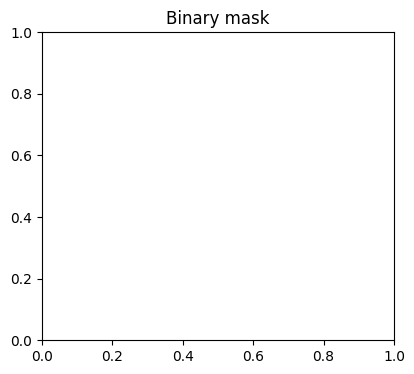

In [11]:
plot_image(data=l_fits[200])